#Group 1

Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Bigioggera

This notebook contains the code used to compute the bbox ratio of images both in the train/val and the test set. More precisely, the bbox ratio is defined as the ratio of the area of the bounding box and the area of the whole image.

In [2]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_val = pd.read_csv('/content/drive/MyDrive/correct_bboxes.csv').drop('Unnamed: 0', axis = 1)

for i in range(len(train_val['pic_name'])): 
  train_val.loc[i, 'path_name'] = '/content/drive/MyDrive/Contexts/' + train_val.loc[i, 'pic_name']

In [ ]:
#Generation of the families labels
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

for i in range(len(train_val['path_name'])):
  train_val.loc[i, 'family'] = family[train_val.loc[i, 'species']]

train_val.loc[train_val['family'] == 'mammalia', 'family_label'] = 0
train_val.loc[train_val['family'] == 'aves', 'family_label'] = 1
train_val.loc[train_val['family'] == 'reptilia', 'family_label'] = 2
train_val.loc[train_val['family'] == 'insecta', 'family_label'] = 3

In [ ]:
#Function to compute the bbox ratio
def bbox_ratio(image):
  if len(image.shape) == 2:
    return image[image == 0].shape[0]/image.shape[0]*image.shape[1]
  else:
    return image[(image[:,:,0] == 0)&(image[:,:,1] == 0)&(image[:,:,2] == 0)].shape[0]/(image.shape[0]*image.shape[1])

In [ ]:
#Computation of the bbox ratio of each image
for i in tqdm(range(len(train_val['path_name']))):
  train_val.loc[i, 'bbox_ratio'] = bbox_ratio(np.array(PIL.Image.open(train_val.loc[i, 'path_name'])))

100%|██████████| 13298/13298 [37:18<00:00,  5.94it/s]


In [ ]:
train_val.to_csv('/content/drive/MyDrive/bbox_ratios.csv')

In [ ]:
train_val = pd.read_csv('/content/drive/MyDrive/bbox_ratios.csv')

#BBox Ratios Distributions (Train/Val)

In this section, the distributions of the bbox ratios for each species and family are obtained.

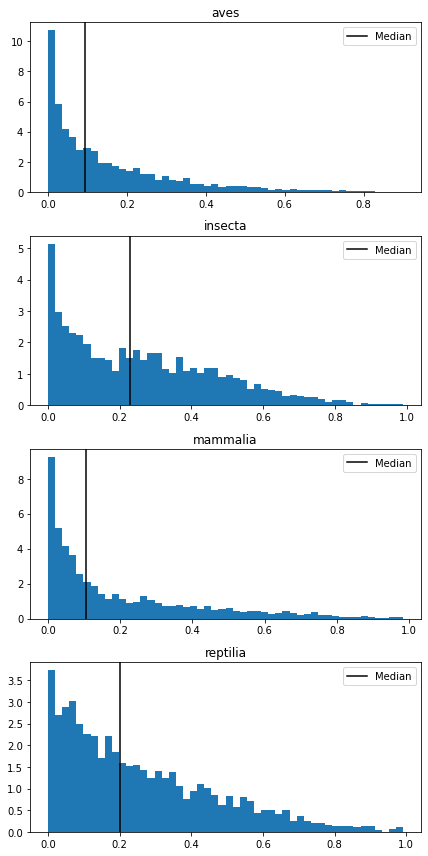

In [ ]:
#Generation of the bbox ratios distributions for each family
families = ['aves', 'insecta', 'mammalia', 'reptilia']
fig, axs = plt.subplots(4, figsize = (6,12))
for i in range(4):
  family = families[i]
  axs[i].set_title(family)
  axs[i].hist(train_val.loc[(train_val['family'] == family) & (train_val['bbox_ratio'] < 1), 'bbox_ratio'], bins = 50, density = True) 
  axs[i].axvline(train_val.loc[(train_val['family'] == family) & (train_val['bbox_ratio'] < 1), 'bbox_ratio'].median(), color = 'black', label = 'Median')
  axs[i].legend()
plt.tight_layout()
plt.show()

As it's possible to see, the distributions of the "aves" and the "mammalia" families are more skewed toward 0, indicating the presence of smaller bounding boxes. Thus, for these families, context is likely to be relevant, since it takes a greater portion of the image with respect to the animal.

In [ ]:
#Generation of the families labels
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

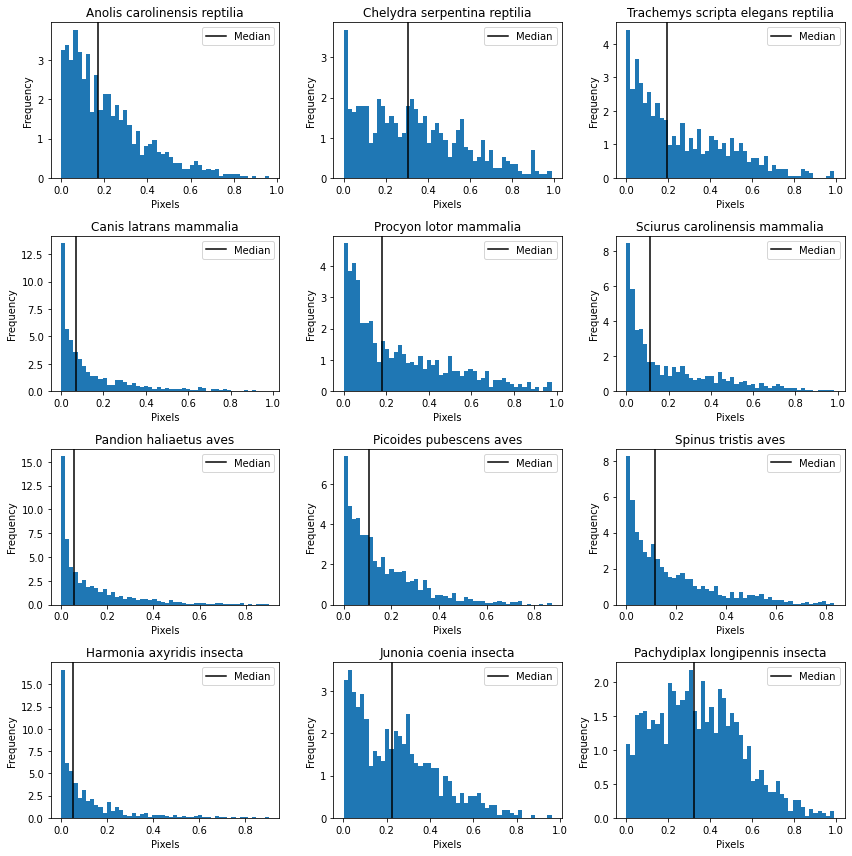

In [ ]:
#Generation of the bboxes distributions for each species
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie) & (train_val['bbox_ratio'] < 1), 'bbox_ratio'], bins = 50, density = True)
  plt.axvline(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie) & (train_val['bbox_ratio'] < 1), 'bbox_ratio'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As it's possible to see, there exist clear differences also within each family. In general, context is likely to be less powerful for species with high bbox ratio (such as Pachydiplax longipennis), while it's likely to be more effective for species with low bboxes ratios (such as Canis latrans, Pandion haliaetus, and Harmonia axyridis).

#BBox Ratios Distributions (Test)

In this section, the same previous steps are repeated for the test images, to obtain additional features which are to be used in the error analysis.

In [ ]:
logit = pd.read_csv('/content/drive/MyDrive/final_logit.csv').drop('Unnamed: 0', axis = 1)
logit.head()

,masked,sift,contrast,bright,species,path,vanilla,bbcontent,mixed,family,red,green,blue,average_0,average_1,average_2,diff_cont_red,diff_cont_green,diff_cont_blue
0,1,156,44.678057,122.619973,Pandion haliaetus,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,75.529122,11.546985,28.336603,96.900701,142.450679,192.453651,-25.216641,15.383413,86.988780
1,0,2784,76.915200,80.271130,Spinus tristis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,11.764276,0.255391,0.093554,123.198697,126.486752,101.010407,1.081354,-0.580514,-4.454465
2,1,330,96.223408,195.855005,Pachydiplax longipennis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,insecta,50.937013,12.645696,16.546658,103.198176,109.649786,70.611125,-18.919167,-17.417480,-34.853747
3,0,1671,92.882461,46.955006,Canis latrans,/content/drive/MyDrive/Animals_masked/Animals_...,0,0,0,mammalia,32.302684,5.813796,10.957970,134.831277,132.248096,141.998666,12.713934,5.180830,36.533795
4,0,3032,84.739734,85.638236,Trachemys scripta elegans,/content/drive/MyDrive/Animals_masked/Animals_...,1,0,0,reptilia,9.112623,1.590392,14.203597,136.216462,127.411422,100.480382,14.099119,0.344155,-4.984490


In [ ]:
#Computation of the bbox ratios of test images
for i in range(len(logit['path'])):
  if logit.loc[i,'path'][-7:-4] == '(1)' or logit.loc[i,'path'][-7:-4] == '(2)' or logit.loc[i,'path'][-7:-4] == '(3)':
    logit.loc[i, 'path'] = logit.loc[i, 'path'][:-7] + logit.loc[i, 'path'][-4:]

for i in tqdm(range(len(logit['path']))):
  logit.loc[i, 'bbox_ratio'] = bbox_ratio(np.array(PIL.Image.open(logit.loc[i, 'path'])))

100%|██████████| 2564/2564 [08:28<00:00,  5.04it/s]


In [ ]:
logit['bbox_ratio'] = logit['bbox_ratio']*100

In [ ]:
logit.to_csv('/content/drive/MyDrive/final_logit.csv')

In [4]:
test = pd.read_csv('/content/drive/MyDrive/final_logit.csv')
test.head()

,Unnamed: 0,masked,sift,contrast,bright,species,path,vanilla,bbcontent,mixed,...,red,green,blue,average_0,average_1,average_2,diff_cont_red,diff_cont_green,diff_cont_blue,bbox_ratio
0,0,1,156,44.678057,122.619973,Pandion haliaetus,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,...,75.529122,11.546985,28.336603,96.900701,142.450679,192.453651,-25.216641,15.383413,86.988780,16.103542
1,1,0,2784,76.915200,80.271130,Spinus tristis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,...,11.764276,0.255391,0.093554,123.198697,126.486752,101.010407,1.081354,-0.580514,-4.454465,18.777824
2,2,1,330,96.223408,195.855005,Pachydiplax longipennis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,...,50.937013,12.645696,16.546658,103.198176,109.649786,70.611125,-18.919167,-17.417480,-34.853747,8.251173
3,3,0,1671,92.882461,46.955006,Canis latrans,/content/drive/MyDrive/Animals_masked/Animals_...,0,0,0,...,32.302684,5.813796,10.957970,134.831277,132.248096,141.998666,12.713934,5.180830,36.533795,0.105000
4,4,0,3032,84.739734,85.638236,Trachemys scripta elegans,/content/drive/MyDrive/Animals_masked/Animals_...,1,0,0,...,9.112623,1.590392,14.203597,136.216462,127.411422,100.480382,14.099119,0.344155,-4.984490,14.478659


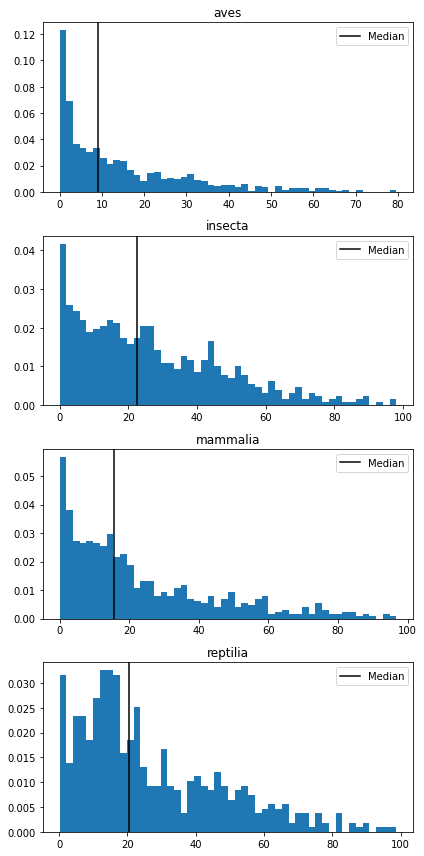

In [6]:
#Generation of the bbox ratios distributions for each family of test images
families = ['aves', 'insecta', 'mammalia', 'reptilia']
fig, axs = plt.subplots(4, figsize = (6,12))
for i in range(4):
  family = families[i]
  axs[i].set_title(family)
  axs[i].hist(test.loc[(test['family'] == family) & (test['bbox_ratio'] < 100), 'bbox_ratio'], bins = 50, density = True) 
  axs[i].axvline(test.loc[(test['family'] == family) & (test['bbox_ratio'] < 100), 'bbox_ratio'].median(), color = 'black', label = 'Median')
  axs[i].legend()
plt.tight_layout()
plt.show()

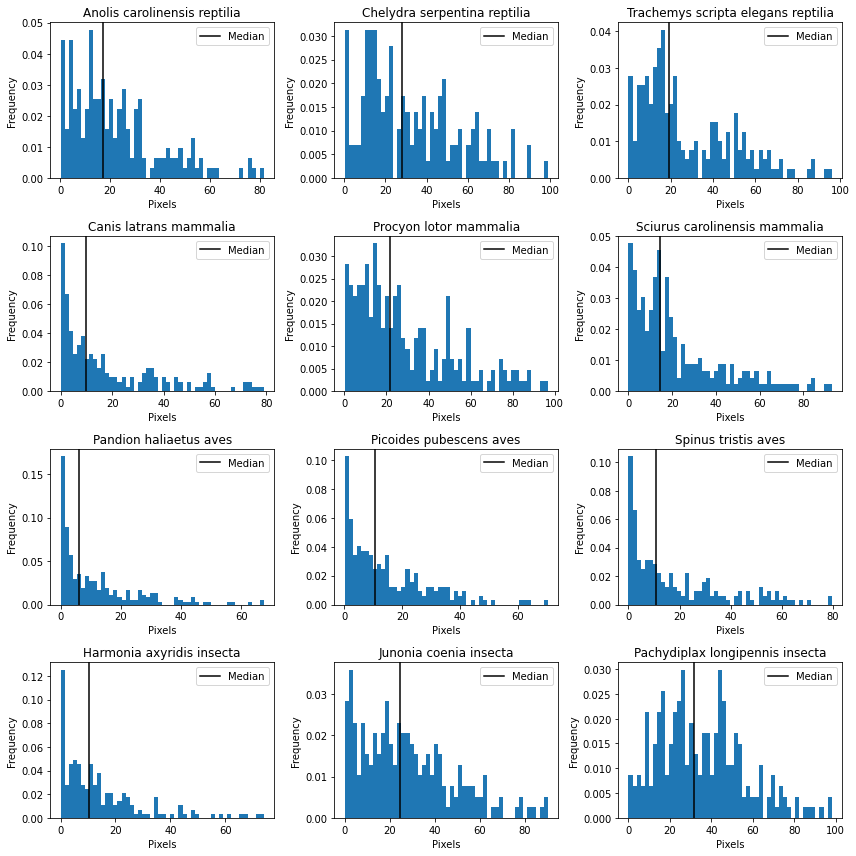

In [10]:
#Generation of the families labels
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

#Generation of the bboxes distributions for each species of test images
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(test.loc[(test['family'] == family[specie]) & (test['species'] == specie) & (test['bbox_ratio'] < 100), 'bbox_ratio'], bins = 50, density = True)
  plt.axvline(test.loc[(test['family'] == family[specie]) & (test['species'] == specie) & (test['bbox_ratio'] < 100), 'bbox_ratio'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As it's possible to see, despite the fewer data, the distributions are consistent with those obtained in the train/val set.